In [437]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

from numpy.fft import fftn as ft
from numpy.fft import ifftshift 

from scipy.optimize import curve_fit

my_size = 64
my_sigma = 2
num_photons = 5E3

object = np.zeros([mysize, mysize])

mypos = [30,35]

object[mypos[0],mypos[1]] = 1

image = scipy.ndimage.gaussian_filter(object, sigma = [my_sigma, my_sigma])

image = image/np.sum(image)*num_photons

image = np.random.poisson(image)

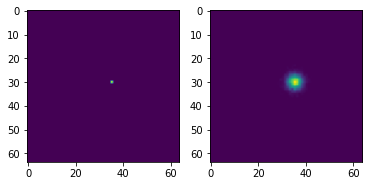

In [438]:
plt.subplot(121)
plt.imshow(object)

plt.subplot(122)
plt.imshow(image)

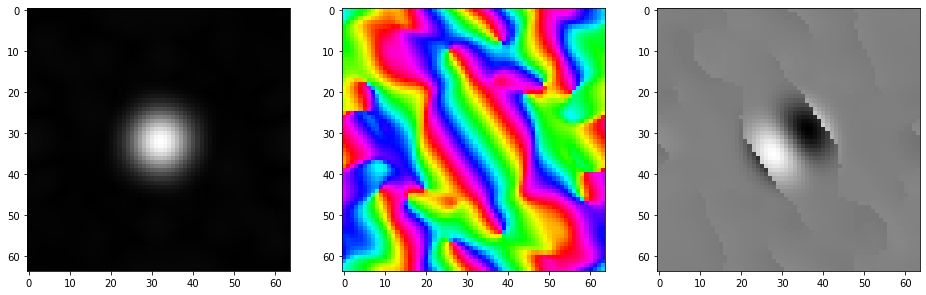

In [439]:
image_ft  = np.fft.ifftshift(ft(np.fft.fftshift(image)))

plt.figure(figsize = [16, 16]) 
plt.subplot(131)
plt.imshow(np.abs(image_ft), cmap = 'gray')

plt.subplot(132)
plt.imshow(np.angle(image_ft), cmap = 'hsv')

plt.subplot(133)
plt.imshow(np.abs(image_ft) * np.angle(image_ft), cmap = 'gray')

In [440]:
# curve fit in real space

def gauss2d(xy_mesh, a, y0, x0, sigma):
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    result = a*np.exp(-((x-x0)**2+(y-y0)**2)/(2*sigma**2))
    
    return np.ravel(result)


x = np.arange(mysize)
y = np.arange(mysize)
xy_mesh = np.meshgrid(x,y)

my_p0 = [np.max(image), np.where(image == np.max(image))[0][0], np.where(image == np.max(image))[1][0], 1]
my_bounds=(0, [np.inf, my_size, my_size, np.inf])

fit_params, cov_mat = curve_fit(gauss2d, xy_mesh, np.ravel(image), p0 = my_p0, bounds = my_bounds)

print(fit_params)

[196.60214913  29.98208892  35.03885418   2.01239133]


[ 0.94159909  4.91277762 -2.07749208  1.57078082]
[-0.2568386   0.17748768]


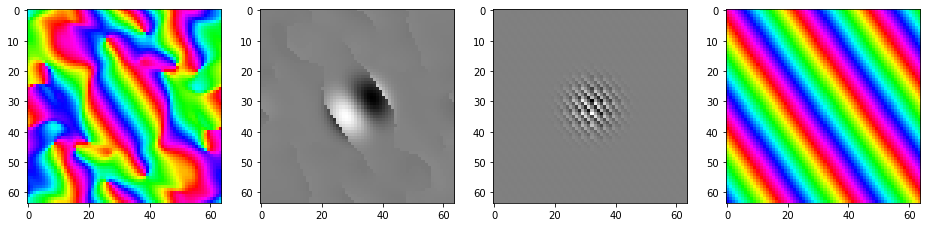

In [441]:
# curve fit in fourier space

def phase_ramp_2d_damped(xy_mesh, a, sigma, kx, ky):
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    x0 = x.shape[0]/2
    y0 = x.shape[1]/2
    
    my_abs = a*np.exp(-((x-x0)**2+(y-y0)**2)/(2*sigma**2))
    
    my_phase = np.angle(np.exp(1j*(kx*(x-x0) + ky*(y-y0))))
    
    my_tot = my_abs * my_phase
        
    return np.ravel(my_tot)

def phase_ramp_2d(xy_mesh, kx, ky):
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    x0 = x.shape[0]/2
    y0 = x.shape[1]/2
    
    x = x - x0
    y = y - y0
    
    my_phase = np.angle(np.exp(1j*(kx*x + ky*y)))
    #my_phase = kx*x + ky*y
        
    return np.ravel(my_phase)



x = np.arange(mysize)
y = np.arange(mysize)
xy_mesh = np.meshgrid(x,y)

phase_ramp = np.abs(image_ft) * np.angle(image_ft)

my_p0 = [1, 5, 0.1, 0.1]
my_bounds=([0, 0, -np.inf, -np.inf], np.inf)

fit_params, cov_mat = curve_fit(phase_ramp_2d_damped, xy_mesh, np.ravel(phase_ramp), \
                                p0 = my_p0, bounds = my_bounds)

print(fit_params)

my_fit_damp = phase_ramp_2d_damped(xy_mesh, fit_params[0], fit_params[1], fit_params[2], fit_params[3])

my_p0 = [0.3, -0.2]
my_bounds=(-10, 10)

my_sigma = 1/np.abs(image_ft)

fit_params, cov_mat = curve_fit(phase_ramp_2d, xy_mesh, np.ravel(np.angle(image_ft)), \
                                p0 = my_p0, bounds = my_bounds, sigma = np.ravel(my_sigma))

print(fit_params)

my_fit_phase = phase_ramp_2d(xy_mesh, fit_params[0], fit_params[1])


plt.figure(figsize = [16, 16]) 
plt.subplot(141)
plt.imshow(np.angle(image_ft), cmap = 'hsv')

plt.subplot(142)
plt.imshow(np.abs(image_ft) * np.angle(image_ft), cmap = 'gray')

plt.subplot(143)
plt.imshow(np.reshape(my_fit_damp,[my_size, my_size]), cmap = 'gray')

plt.subplot(144)
plt.imshow(np.reshape(my_fit_phase,[my_size, my_size]), cmap = 'hsv')

In [359]:
(x,y) = xy_mesh
x.shape

(64, 64)